In [6]:
import random
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import yeojohnson
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from itertools import combinations
import pandas as pd
import numpy as np
import keras
from tensorflow.keras import layers, regularizers, Sequential, Model
from tensorflow.keras.optimizers import Adam

from tensorflow.keras import layers, regularizers
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from sklearn.preprocessing import MinMaxScaler

random.seed(30)
df = pd.read_csv("data/us_change.csv", index_col=0)
df

,Quarter,Consumption,Income,Production,Savings,Unemployment
1,1970 Q1,0.618566,1.044801,-2.452486,5.299014,0.9
2,1970 Q2,0.451984,1.225647,-0.551459,7.789894,0.5
3,1970 Q3,0.872872,1.585154,-0.358652,7.403984,0.5
4,1970 Q4,-0.271848,-0.239545,-2.185691,1.169898,0.7
5,1971 Q1,1.901345,1.975925,1.909764,3.535667,-0.1
...,...,...,...,...,...,...
194,2018 Q2,0.983112,0.661825,1.117424,-2.723974,0.0
195,2018 Q3,0.853181,0.806271,1.256722,-0.085686,-0.3
196,2018 Q4,0.356512,0.695142,0.948148,5.031337,0.2
197,2019 Q1,0.282885,1.100753,-0.488206,9.760287,-0.1


In [7]:
def convert_to_period(quarter):
    """
    Function to convert a string to a pandas period object. 
    Checks if the input is a string in the form '2019 Q1' or already a Period.
    """
    if isinstance(quarter, pd.Period):
        return quarter
    year, quarter_str = quarter.split()
    year = int(year)
    quarter = int(quarter_str[-1])
    return pd.Period(year=year, quarter=quarter, freq='Q')

df['Quarter'] = df['Quarter'].apply(convert_to_period)

In [8]:
import numpy as np
import pandas as pd
from tensorflow.keras import layers, regularizers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


sequence_length = 4  # Número de trimestres na janela de tempo
test_size = 0.2
val_size = 0.2


scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['Income', 'Production', 'Savings', 'Unemployment', 'Consumption']])

def create_sequences(data, target_idx, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length, :-1])
        y.append(data[i + seq_length, target_idx])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data, target_idx=-1, seq_length=sequence_length)


X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=test_size, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=val_size, random_state=42)

inputs = layers.Input(shape=(sequence_length, X.shape[2]))

x = layers.Conv1D(4, 2, activation="leaky_relu", kernel_regularizer=regularizers.l2(0.001), padding='same')(inputs)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling1D(2, padding='same')(x)
x = layers.Dropout(0.2)(x)

x = layers.Conv1D(4, 2, activation="leaky_relu", kernel_regularizer=regularizers.l2(0.001), padding='same')(x)
x = layers.BatchNormalization()(x)

x = layers.Dropout(0.2)(x)

x = layers.Conv1D(4, 2, activation="leaky_relu", kernel_regularizer=regularizers.l2(0.001), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.GlobalAveragePooling1D()(x)  

outputs = layers.Dense(1, kernel_regularizer=regularizers.l2(0.001))(x)
model = models.Model(inputs, outputs)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 4, 4)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 4, 4)           │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 4, 4)           │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 2, 4)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2, 4)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 2, 4)           │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 2, 4)           │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 2, 4)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 2, 4)           │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 2, 4)           │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 4)              │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 161 (644.00 B)

 Trainable params: 137 (548.00 B)

 Non-trainable params: 24 (96.00 B)

In [9]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
)


test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - loss: 0.7414 - mae: 0.6853 - val_loss: 0.4509 - val_mae: 0.6464
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.7163 - mae: 0.6744 - val_loss: 0.4480 - val_mae: 0.6440
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.7760 - mae: 0.6589 - val_loss: 0.4450 - val_mae: 0.6415
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6075 - mae: 0.6293 - val_loss: 0.4352 - val_mae: 0.6336
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6363 - mae: 0.6227 - val_loss: 0.4233 - val_mae: 0.6242
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.5372 - mae: 0.5906 - val_loss: 0.4094 - val_mae: 0.6131
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.4771 - mae: 0.5584 - val_loss: 0.3957 - val_mae: 0.6020
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.5068 - mae: 0.5473 - val_loss: 0.3823 - val_mae: 0.5909
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.4963 - mae: 0.5310 -

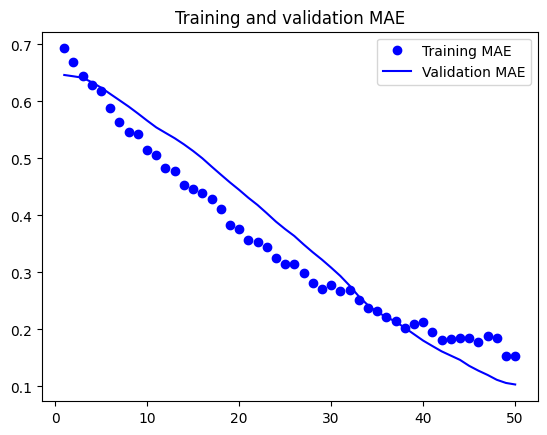

In [10]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [26]:
from sktime.utils.plotting import plot_series

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


(<Figure size 1600x400 with 1 Axes>,
 <Axes: title={'center': 'Train, Test and Predictions'}, ylabel='y_train'>)

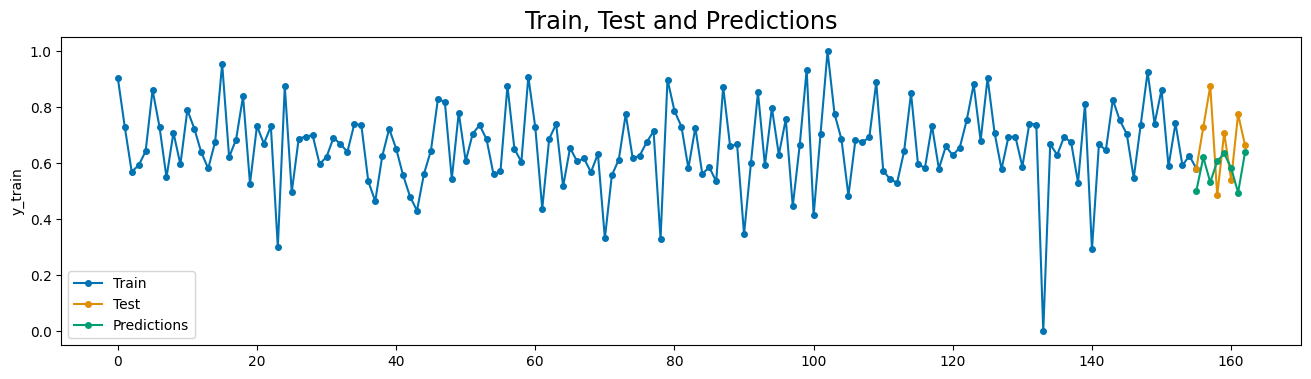

In [36]:
df_plot = pd.DataFrame()
df_plot.index = range(len(y_train) + len(y_test))

df_plot["y_train"] = np.nan
df_plot["y_test"] = np.nan
df_plot["y_pred"] = np.nan
df_plot.loc[:len(y_train)-1, "y_train"] = y_train
df_plot.loc[len(y_train):, "y_test"] = y_test
df_plot.loc[len(y_train):, "y_pred"] = model.predict(X_test).reshape(-1)

df_plot.loc[len(y_train), "y_train"] = df_plot.loc[len(y_train), "y_test"] # Connecting train and test plot lines


plot_series(
    df_plot["y_train"],
    df_plot["y_test"],
    df_plot["y_pred"],
    labels=["Train", "Test", "Predictions"],
    title="Train, Test and Predictions",
)